<a href="https://colab.research.google.com/github/Mafaz03/Test-Checkpoints/blob/main/midas_based_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Importing Dependencies

In [1]:
#Dependencies related to predictions and visualization
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
#Dependencies related to files
import os
from pathlib import Path
import requests
import zipfile

In [3]:
#Supporting module
import time
try:
  import timm
except:
  !pip install timm -q
  import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00


In [4]:
#to measure itteration and total timefor execution
from tqdm import tqdm_notebook as tqdm

In [5]:
#Setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#2 Setting MiDaS

In [6]:
#Imorting small midas model

model_type = "MiDaS_small"

midas = torch.hub.load("intel-isl/MiDaS" , model_type)

midas.to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:01<00:00, 62.0MB/s]


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [7]:
#importing large and small transforms for midas
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")

transform = midas_transforms.small_transform

transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7f5eb779ef80>
    <function transforms.<locals>.<lambda> at 0x7f5eb779f010>
)

#3 Downloading image sequence

In [8]:
data_path = Path("data/")
seq_path = data_path / "seq_path"

seq_path.mkdir(parents = True , exist_ok = True)

file_name = "simulation_sequence.zip"
with open(data_path / file_name , "wb") as f:
  request = requests.get("https://github.com/Mafaz03/Datasets/raw/Sequence/Path_simulation_sequence/Path_simulation_sequence.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / file_name) as zip:
  zip.extractall(seq_path)

In [9]:
seq0001 = cv.imread("/content/data/seq_path/Path_simulation0001.png")

seq0001 = cv.cvtColor(seq0001, cv.COLOR_BGR2RGB)#convering cv2's BGR to RGB

size = seq0001.shape[:2]
print(f"image size : {size}")

image size : (1080, 1920)


#3.1 Plotting few images sequence

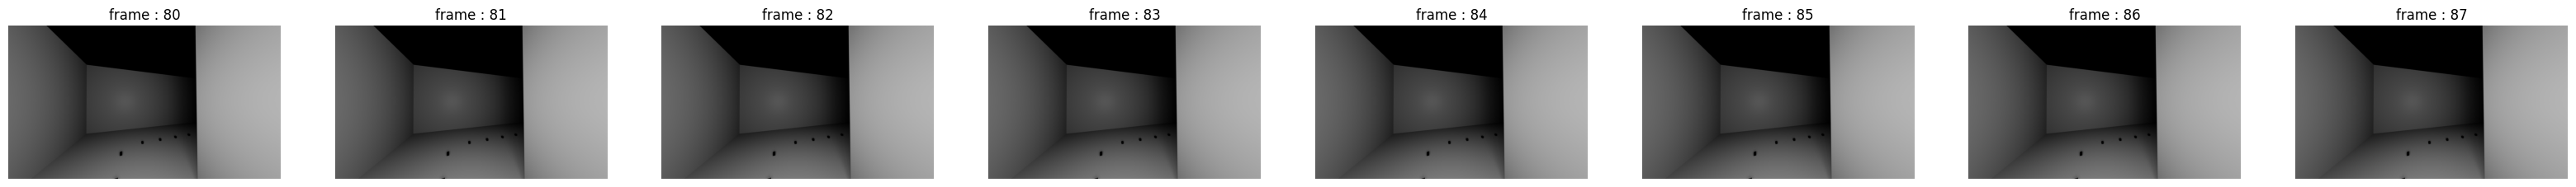

In [10]:
plt.figure(figsize = (40 , 40))
num_of_img = 8
start = 80


for seq in range(num_of_img):
  plt.subplot(1,num_of_img,seq+1)
  image = plt.imread(seq_path/ f"Path_simulation00{start + num_of_img}.png")
  plt.imshow(image)
  plt.title(f"frame : {start + seq}")
  plt.axis("off")

#4 Predicting

In [11]:
sequence_transformed = transform(seq0001).to(device)
print(sequence_transformed.shape)

torch.Size([1, 3, 128, 256])


In [12]:
start_time = time.time()

brighest_points_seq = {}

with torch.no_grad():
  prediction = midas(sequence_transformed)

  prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size = size,
    mode="bicubic",
    align_corners=False,
  ).squeeze()

  depth_map = prediction.cpu().numpy()
  depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_data = depth_map
  depth_map = (depth_map*255).astype(np.uint8)
  depth_map = cv.applyColorMap(depth_map , cv.COLORMAP_MAGMA)

end_time = time.time()
print(f"Time taken for execution : {end_time - start_time}")

Time taken for execution : 6.93272852897644


#5 Plotting predictions

(-0.5, 1919.5, 1079.5, -0.5)

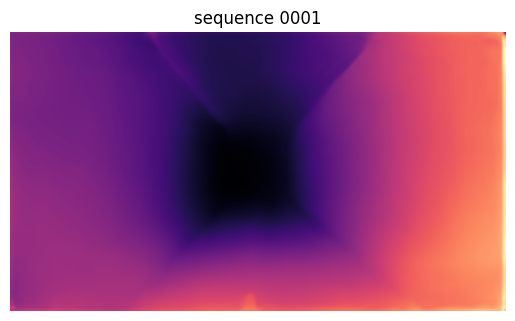

In [13]:
depth_map = cv.cvtColor(depth_map , cv.COLOR_BGR2RGB)
plt.imshow(depth_map)
plt.title("sequence 0001")
plt.axis("off")

##5.1 Cropping predictions

In [14]:
depth_map_cropped = depth_map[ 400 : 650 ,  0 : size[1] ] #Cropping

In [15]:
size_cropped = depth_map_cropped.shape[:2]
depth_map.shape
size_cropped , depth_map.shape

((250, 1920), (1080, 1920, 3))

(-0.5, 1919.5, 249.5, -0.5)

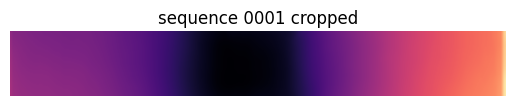

In [16]:
plt.imshow(depth_map_cropped)
plt.title("sequence 0001 cropped")
plt.axis("off")

##5.2 Saving croped predictions

In [17]:
dept_seq_path = data_path / "Depth_map_sequence"
dept_seq_path.mkdir(parents = True , exist_ok = True)

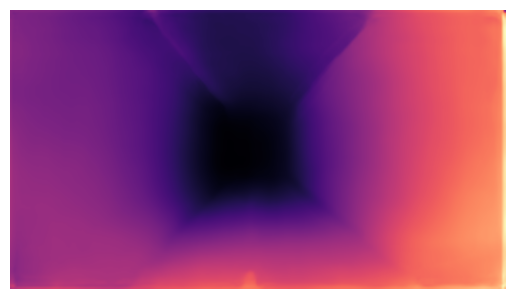

In [18]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
file_name = "Depth_map_" + str(1)
fig.savefig(f"/content/data/Depth_map_sequence/{file_name}")
plt.axis("off")
ax.imshow(depth_map)

##5.3 Segmenting croped predictions

In [19]:
def segments(amount : int , width : int) -> list[tuple[int]]:

  slice_list = []
  amount = 10

  sections = width // amount

  beg = sections
  temp = 0
  for batches in range(amount):
    section = sections + temp

    if batches == 0:
      # print( 0 , section)
      slice_list.append((0 , sections))
    else:
      # print(beg , beg + sections)
      slice_list.append((beg , beg + sections))
      beg += sections

  return slice_list

In [20]:
seg = segments(amount = 10 , width = size_cropped[1])
seg

[(0, 192),
 (192, 384),
 (384, 576),
 (576, 768),
 (768, 960),
 (960, 1152),
 (1152, 1344),
 (1344, 1536),
 (1536, 1728),
 (1728, 1920)]

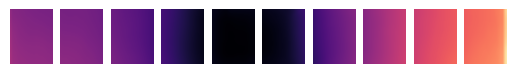

In [21]:
brightest_points = {}

for segments in range(len(seg)):
  plt.subplot(1 , len(seg) , segments + 1)
  depth_map_cropped_seg = depth_map_cropped[0 : size_cropped[0] , seg[segments][0] : seg[segments][1] ]
  cropped_data = depth_map_data[0 : size_cropped[0] , seg[segments][0] : seg[segments][1] ]
  brightest_point = np.max(cropped_data)
  brightest_points[segments + 1] = round(brightest_point  , 2)
  plt.imshow(depth_map_cropped_seg)
  plt.axis("off")


In [22]:
brightest_points

{1: 0.41,
 2: 0.36,
 3: 0.36,
 4: 0.28,
 5: 0.18,
 6: 0.25,
 7: 0.43,
 8: 0.61,
 9: 0.72,
 10: 1.0}

#6 Plotting polar plot

In [23]:
def polar_plot(brightest_points : dict , title : str , marker , save_path : str , seq : int , rotation = 0 ):
  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  ax.set_rmax(1)
  ax.set_rlabel_position(0)
  degrees= 360/len(brightest_points)
  theta=np.deg2rad(np.arange(0 + rotation ,361 + rotation ,degrees))[1:]
  theta = np.append(theta , theta[0])
  brightest_points[len(brightest_points)+1] = list(brightest_points.values())[0]

  ax.plot(theta , brightest_points.values() , marker = marker)
  if save_path != None:
    fig.savefig(f"/content/data/Depth_map_sequence/Depth_map_{seq}")
  plt.title(title)

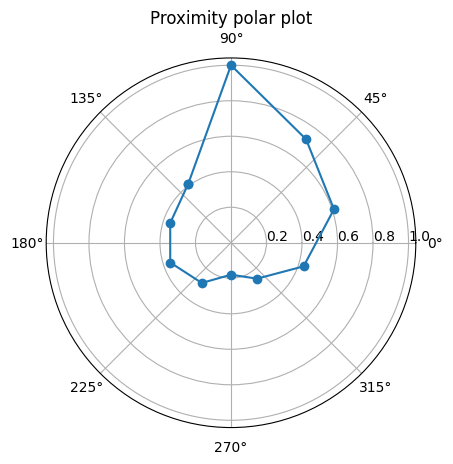

In [24]:
polar_plot(brightest_points , title = "Proximity polar plot" ,
           marker = "o" , rotation = 90 ,
           save_path = "/content/data/Depth_map_sequence",
           seq = 1) #closest proximity value is lower

In [25]:
dept_seq_path = data_path / "Depth_map_sequence"
dept_seq_path.mkdir(parents = True , exist_ok = True)

In [26]:
def segments(amount : int , width : int) -> list[tuple[int]]:

  slice_list = []
  amount = 10

  sections = width // amount

  beg = sections
  temp = 0
  for batches in range(amount):
    section = sections + temp

    if batches == 0:
      # print( 0 , section)
      slice_list.append((0 , sections))
    else:
      # print(beg , beg + sections)
      slice_list.append((beg , beg + sections))
      beg += sections

  return slice_list

In [27]:
seg = segments(amount = 10 , width = size_cropped[1])
seg

[(0, 192),
 (192, 384),
 (384, 576),
 (576, 768),
 (768, 960),
 (960, 1152),
 (1152, 1344),
 (1344, 1536),
 (1536, 1728),
 (1728, 1920)]

In [54]:
4 - len(str(32))

2

In [57]:
def convert0(num : int) -> int:
  if len(str(num)) <= 4:
    appendings = 4 - len(str(num))
    return(str(0)*appendings + str(num))

In [60]:
convert0(6534)

'6534'

In [ ]:
seq0001 = cv.imread("/content/data/seq_path/Path_simulation0001.png")

seq0001 = cv.cvtColor(cv.imread("/content/data/seq_path/Path_simulation0001.png"),
                      cv.COLOR_BGR2RGB) #convering cv2's BGR to RGB

sequence_transformed = transform(seq0001).to(device)

<ipython-input-28-3f6133e221d4>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_seq in tqdm(range(1 , num_of_images + 1)) :


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-28-3f6133e221d4>:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 , len(seg) , segments + 1)


Time taken for execution : 1.448638677597046


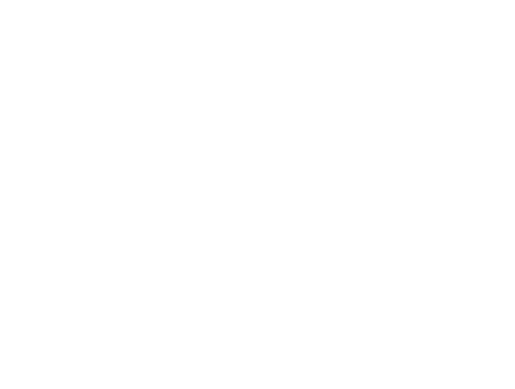

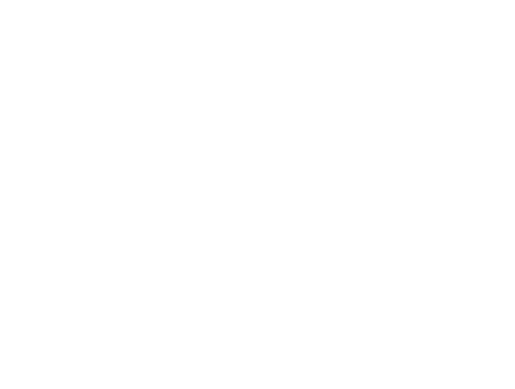

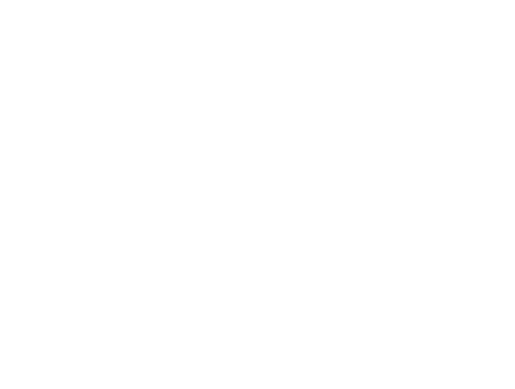

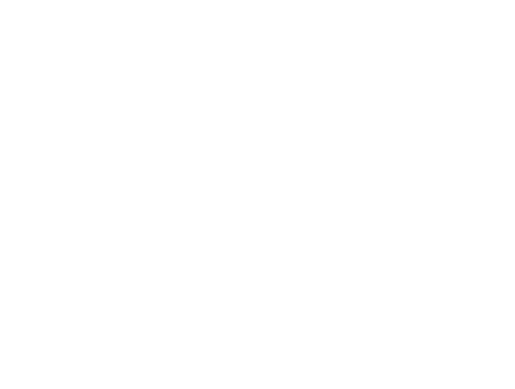

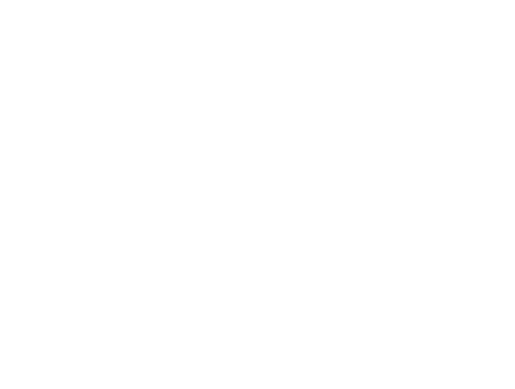

In [28]:
start_time = time.time()

brightest_points_seq = {}

num_of_images = 5
for image_seq in tqdm(range(1 , num_of_images + 1)) :

  brightest_points = {}

  with torch.no_grad():


    seq = cv.cvtColor(cv.imread("/content/data/seq_path/Path_simulation0001.png"),
                      cv.COLOR_BGR2RGB) #convering cv2's BGR to RGB
    sequence_transformed = transform(seq).to(device)

    prediction = midas(sequence_transformed)

    prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size = size,
      mode="bicubic",
      align_corners=False,
    ).squeeze()

  fig, ax = plt.subplots( nrows=1, ncols=1 )
  depth_map = prediction.cpu().numpy()
  depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_data = depth_map
  depth_map = (depth_map*255).astype(np.uint8)
  depth_map = cv.applyColorMap(depth_map , cv.COLORMAP_MAGMA)

  depth_map_cropped = depth_map[ 400 : 650 ,  0 : size[1] ]
  depth_map_cropped = cv.cvtColor(depth_map_cropped , cv.COLOR_BGR2RGB)

  file_name = "Depth_map_" + str(image_seq)
  fig.savefig(f"/content/data/Depth_map_sequence/{file_name}")
  plt.axis("off")

  for segments in range(len(seg)):
    plt.subplot(1 , len(seg) , segments + 1)
    depth_map_cropped_seg = depth_map_cropped[0 : size_cropped[0] , seg[segments][0] : seg[segments][1] ]
    cropped_data = depth_map_data[0 : size_cropped[0] , seg[segments][0] : seg[segments][1] ]
    brightest_point = np.max(cropped_data)
    brightest_points[segments + 1] = round(brightest_point  , 2)
    plt.axis("off")

end_time = time.time()
print(f"Time taken for execution : {end_time - start_time}")

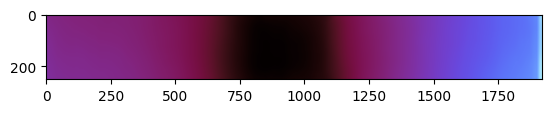

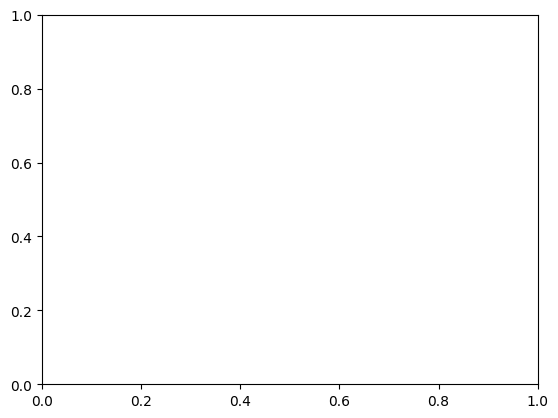

In [29]:
depth_map_cropped = cv.cvtColor(depth_map_cropped , cv.COLOR_BGR2RGB)
plt.imshow(depth_map_cropped)

fig, ax = plt.subplots( nrows=1, ncols=1 )

In [30]:
brightest_points

{1: 0.41,
 2: 0.36,
 3: 0.36,
 4: 0.28,
 5: 0.18,
 6: 0.25,
 7: 0.43,
 8: 0.61,
 9: 0.72,
 10: 1.0}

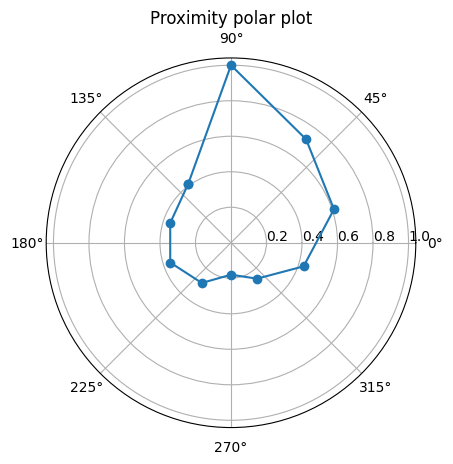

In [31]:
  polar_plot(brightest_points , title = "Proximity polar plot" ,
           marker = "o" , rotation = 90 ,
           save_path = "/content/data/Depth_map_sequence",
           seq = image_seq) #closest proximity value is lower